# Case-by-case analysis
This notebook demonstrates how to visualize which model managed to solve which test-case how often.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
directory = "../data/"

collection = []
for filename in os.listdir(directory):
    if filename.endswith("_results.jsonl"):
        print(filename)
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace(".jsonl_results.jsonl", "").replace("samples_", "")
        collection.append(df)

df = pd.concat(collection)

samples_claude-3-opus-20240229.jsonl_results.jsonl
samples_codellama.jsonl_results.jsonl
samples_gemini-pro.jsonl_results.jsonl
samples_gpt-3.5-turbo-1106.jsonl_results.jsonl
samples_gpt-4-1106-preview.jsonl_results.jsonl
samples_gpt-4-turbo-2024-04-09.jsonl_results.jsonl
samples_reference.jsonl_results.jsonl


In [3]:
df

,task_id,completion,full_response,result,passed,model
0,../test_cases/apply_otsu_threshold_and_count_p...,\nimport cv2\nimport numpy as np\n\ndef apply_...,Here's the completed code with a step-by-step ...,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,False,claude-3-opus-20240229
1,../test_cases/binary_closing.ipynb,\nimport numpy as np\nfrom scipy.ndimage impor...,"Here's the completed code with the plan, impor...",passed,True,claude-3-opus-20240229
2,../test_cases/binary_skeleton.ipynb,\nimport numpy as np\nimport cv2\n\ndef binary...,Here's the completed code with a step-by-step ...,failed: module 'cv2' has no attribute 'ximgproc',False,claude-3-opus-20240229
3,../test_cases/bland_altman.ipynb,\n# Plan:\n# 1. Check if the specified columns...,"Here's the completed code with the plan, impor...",passed,True,claude-3-opus-20240229
4,../test_cases/combine_columns_of_tables.ipynb,\n# Plan:\n# 1. Check if the index column is p...,"Here's the completed code with comments, impor...",failed: Can only compare identically-labeled (...,False,claude-3-opus-20240229
...,...,...,...,...,...,...
565,../test_cases/workflow_batch_process_folder_me...,\n import os\n import pandas as pd\n ...,\n import os\n import pandas as pd\n ...,passed,True,reference
566,../test_cases/workflow_segmentation_counting.i...,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,reference
567,../test_cases/workflow_segmentation_measuremen...,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,reference
568,../test_cases/workflow_segment_measure_umap.ipynb,\n import numpy as np\n import pandas as...,\n import numpy as np\n import pandas as...,passed,True,reference


In [4]:
# Ensure the 'passed' column is boolean for correct processing.
df['passed'] = df['passed'].astype(bool)
# shorten task name
df['task_id'] = [str(t).replace("../test_cases/", "").replace(".ipynb","") for t in df['task_id']]

# Pivot the dataframe to count True 'passed' values for each model-task combination.
pivot_df = df.pivot_table(index='task_id', columns='model', values='passed', aggfunc='mean', fill_value=0)

# Reset the index if 'task_id' needs to be a column instead of an index
pivot_df.reset_index(inplace=True)

# Apply formatting to display only two digits after the decimal point for all columns after the first (task_id column)
pivot_df = pivot_df.round(2)

# Show the transformation result (for verification)
def colorize(styler):
    styler.background_gradient(axis=None, cmap="PiYG")
    return styler

# Apply the formatting within the styling function using .format
pivot_df.style.pipe(colorize).format("{:.1f}", subset=pivot_df.columns[1:])

model,task_id,claude-3-opus-20240229,codellama,gemini-pro,gpt-3.5-turbo-1106,gpt-4-1106-preview,gpt-4-turbo-2024-04-09,reference
0,apply_otsu_threshold_and_count_postiive_pixels,0.0,0.0,0.1,0.0,0.0,0.0,1.0
1,binary_closing,1.0,0.0,0.0,0.1,0.6,0.4,1.0
2,binary_skeleton,0.6,0.1,0.0,0.1,0.9,0.8,1.0
3,bland_altman,1.0,0.2,0.6,1.0,1.0,1.0,1.0
4,combine_columns_of_tables,0.1,0.1,0.7,0.9,1.0,0.8,1.0
5,convex_hull_measure_area,1.0,0.2,0.1,0.8,0.7,0.9,1.0
6,convolve_images,0.7,0.0,0.0,0.1,0.4,0.5,1.0
7,count_number_of_touching_neighbors,0.1,0.0,0.0,0.1,0.2,0.6,1.0
8,count_objects_over_time,0.6,0.1,0.2,0.1,0.5,0.5,1.0
9,count_overlapping_regions,1.0,0.0,0.0,0.4,1.0,1.0,1.0


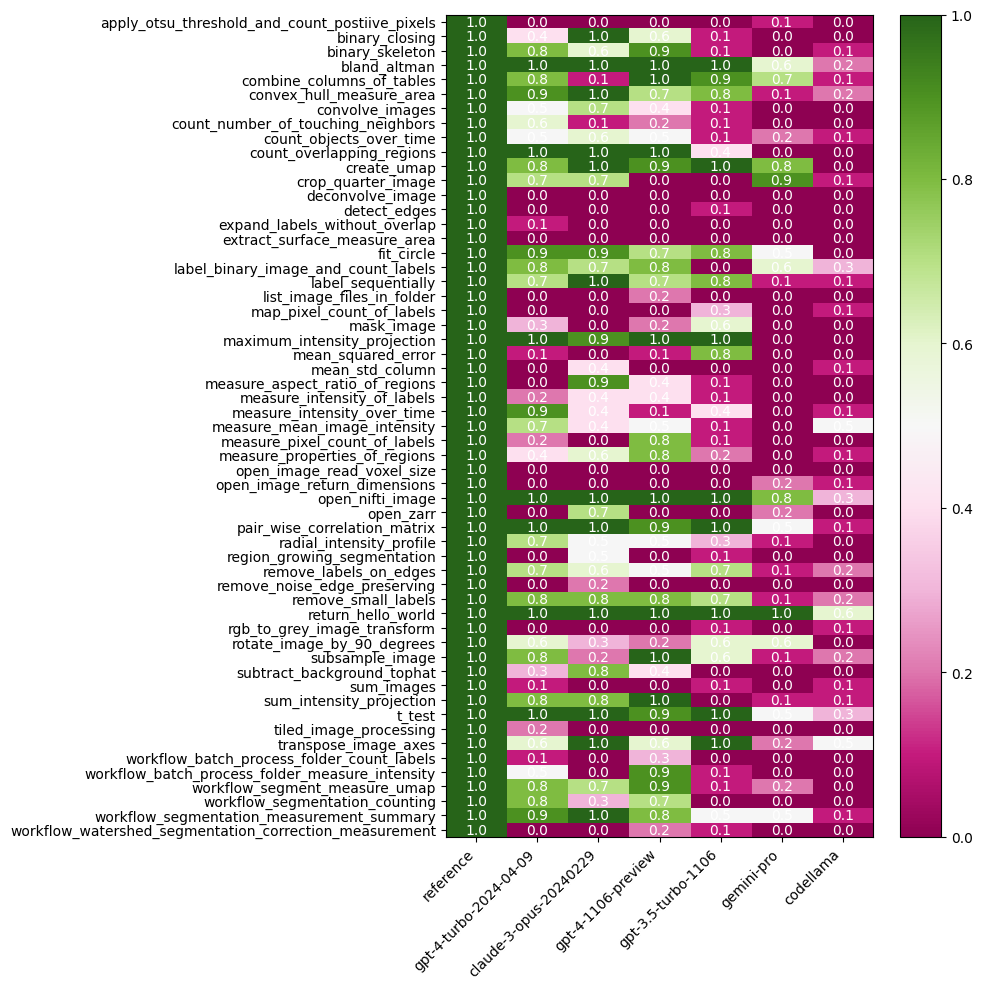

In [5]:
import matplotlib.pyplot as plt
import numpy as np

df = pivot_df

# Separate the numerical data for plotting and the string column for y-axis labels
numerical_data = df.select_dtypes(include=[np.number])
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
numerical_data = numerical_data[mean_values.index]

str_column_values = df['task_id']  # Replace 'str_column' with the actual column name

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(numerical_data, cmap='PiYG', aspect='auto')

# Annotating each cell with the corresponding value
for (i, j), val in np.ndenumerate(numerical_data):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white')

# Setting the column names as x-axis labels
ax.set_xticks(np.arange(len(numerical_data.columns)))
ax.set_xticklabels(numerical_data.columns)

# Setting the string column values as y-axis labels
ax.set_yticks(np.arange(len(str_column_values)))
ax.set_yticklabels(str_column_values)

# Rotating the tick labels for better visibility
plt.xticks(rotation=45, ha="right")

# Showing the color bar and tight_layout for neatness
fig.colorbar(cax)
plt.tight_layout()

plt.savefig("performance_per_task")
plt.show()

In [6]:
pivot_df.describe()

model,claude-3-opus-20240229,codellama,gemini-pro,gpt-3.5-turbo-1106,gpt-4-1106-preview,gpt-4-turbo-2024-04-09,reference
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.0
mean,0.470175,0.087719,0.171930,0.333333,0.464912,0.473684,1.0
std,0.402210,0.136369,0.275651,0.379065,0.386602,0.381504,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.500000,0.000000,0.000000,0.100000,0.500000,0.500000,1.0
75%,0.900000,0.100000,0.200000,0.700000,0.800000,0.800000,1.0
max,1.000000,0.600000,1.000000,1.000000,1.000000,1.000000,1.0


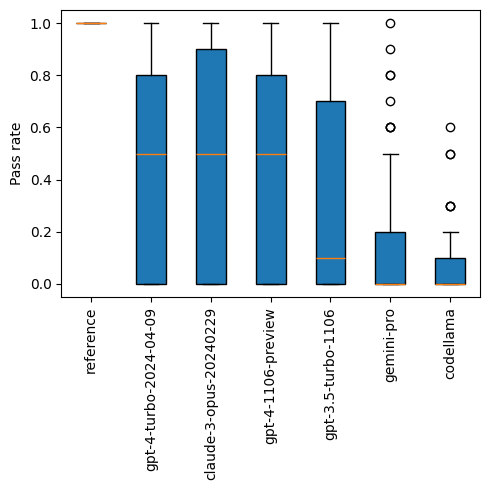

In [7]:
# Assuming pivot_df has 'task_id' as a non-numerical column and the rest are numerical and need to be plotted
numerical_data = pivot_df.drop(columns=['task_id'])

# Calculate the mean of each column and sort these means in descending order
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
ordered_numerical_data = numerical_data[mean_values.index]

# Plotting the boxplot with reordered columns
plt.figure(figsize=(5, 5))
boxplot = plt.boxplot(ordered_numerical_data, patch_artist=True, labels=ordered_numerical_data.columns)

# Adding colors
# colors = ['lightblue'] * len(ordered_numerical_data.columns)
#for patch, color in zip(boxplot['boxes'], colors):
#    patch.set_facecolor(color)

# plt.title('Pass rate for generated BIA Python code')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.ylabel('Pass rate')  # Optionally adjust the label to suit the data context
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()